In [106]:
#main libraries
import os
import re
import pickle
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#importing machine learning libraries
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, KFold, cross_val_score
from sklearn.preprocessing  import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

import plotly 
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff 
from plotly.offline import iplot
from plotly import tools

In [75]:
#import the data
full_df = pd.read_csv('./Bengaluru_House_Data.csv')

In [76]:
full_df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [77]:
full_df = full_df.drop(columns =['availability','balcony','area_type','society'])
full_df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [78]:
full_df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [79]:
full_df['size'].fillna('0 BHK', inplace=True)
full_df['bath'].fillna(0, inplace=True)
full_df['location'].fillna('NA', inplace=True) 
full_df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [80]:
full_df['size'] = full_df['size'].apply(lambda x: int(x.split(' ')[0]))
full_df

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2,1056,2.0,39.07
1,Chikka Tirupathi,4,2600,5.0,120.00
2,Uttarahalli,3,1440,2.0,62.00
3,Lingadheeranahalli,3,1521,3.0,95.00
4,Kothanur,2,1200,2.0,51.00
...,...,...,...,...,...
13315,Whitefield,5,3453,4.0,231.00
13316,Richards Town,4,3600,5.0,400.00
13317,Raja Rajeshwari Nagar,2,1141,2.0,60.00
13318,Padmanabhanagar,4,4689,4.0,488.00


In [81]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        #print(x)
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [82]:
full_df.total_sqft = full_df.total_sqft.apply(convert_sqft_to_num)
full_df.total_sqft

0        1056.0
1        2600.0
2        1440.0
3        1521.0
4        1200.0
          ...  
13315    3453.0
13316    3600.0
13317    1141.0
13318    4689.0
13319     550.0
Name: total_sqft, Length: 13320, dtype: float64

In [83]:
#descriptive statistics summary
full_df['price'].describe()

count    13320.000000
mean       112.565627
std        148.971674
min          8.000000
25%         50.000000
50%         72.000000
75%        120.000000
max       3600.000000
Name: price, dtype: float64

C:\Users\SANTOSH\AppData\Local\Temp\ipykernel_22344\909942682.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




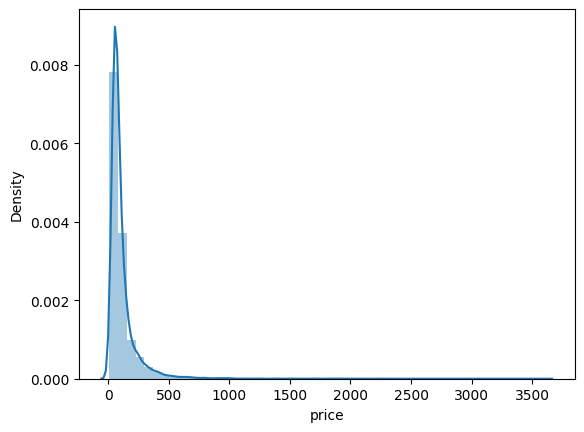

In [84]:
#histogram
sns.distplot(full_df['price']);

In [85]:
#skewness and kurtosis
print(f"Skewness: {full_df['price'].skew()}")
print(f"Kurtosis: {full_df['price'].kurt()}")

Skewness: 8.064468821273252
Kurtosis: 108.16651274550613


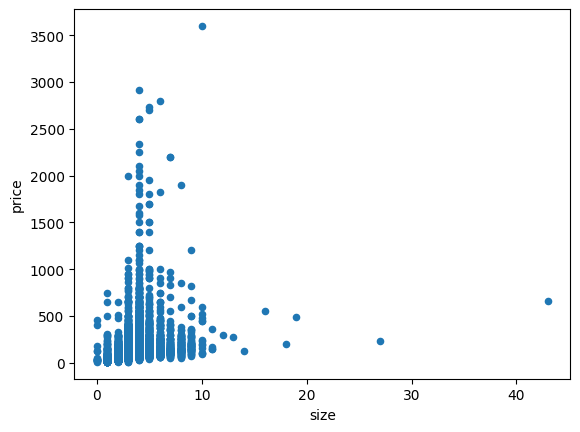

In [86]:
#scatter plot size/price
var = 'size'
data = pd.concat([full_df['price'], full_df[var]], axis=1)
data.plot.scatter(x=var, y='price');

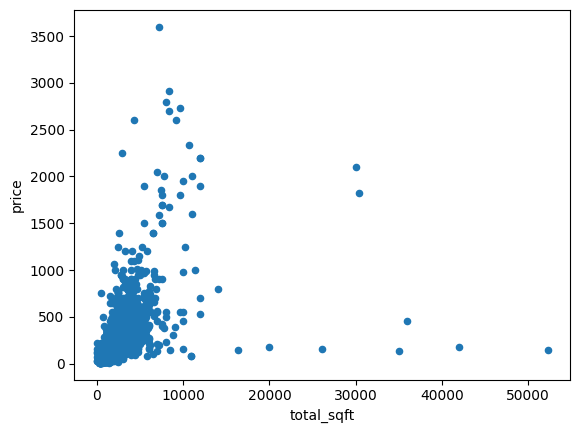

In [87]:
#scatter plot total_sqft/price
var = 'total_sqft'
data = pd.concat([full_df['price'], full_df[var]], axis=1)
data.plot.scatter(x=var, y='price');

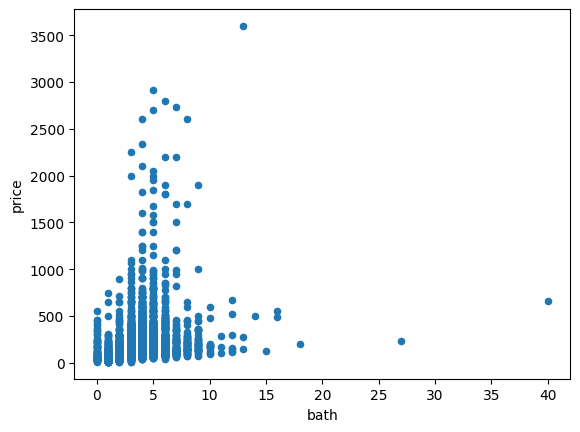

In [88]:
#scatter plot bath/price
var = 'bath'
data = pd.concat([full_df['price'], full_df[var]], axis=1)
data.plot.scatter(x=var, y='price');

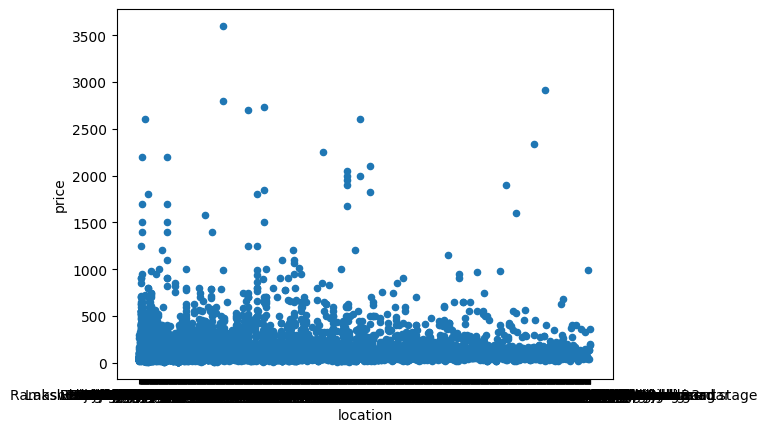

In [89]:
#scatter plot balcony/price
var = 'location'
data = pd.concat([full_df['price'], full_df[var]], axis=1)
data.plot(kind='scatter', x=var, y='price');

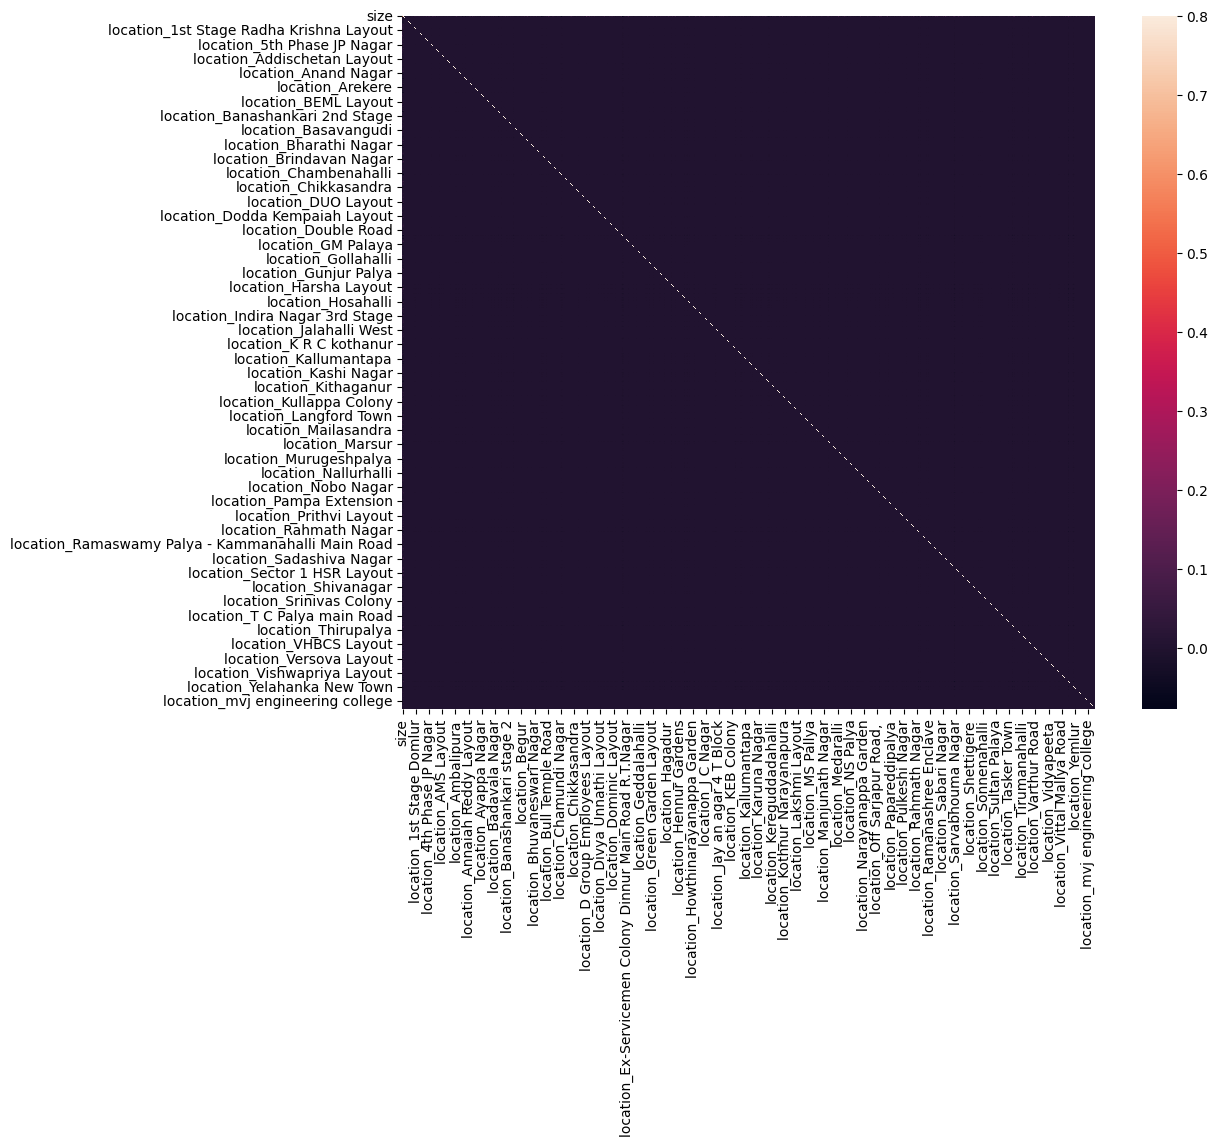

In [74]:
#correlation matrix
corrmat = full_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [90]:
#Using z_scores to remove outliers


cols = ['size', 'total_sqft', 'bath']


def z_score(full_df):
    full_df.columns = [x + "_zscore" for x in full_df.columns.tolist()]
    return ((full_df - full_df.mean())/full_df.std(ddof=0))

In [91]:
z_scores = z_score(full_df[cols])
z_scores['ID'] = z_scores.index
z_scores

,size_zscore,total_sqft_zscore,bath_zscore,ID
0,-0.616724,-0.406689,-0.501216,0
1,0.924362,0.840123,1.717036,1
2,0.153819,-0.096601,-0.501216,2
3,0.153819,-0.031192,0.238201,3
4,-0.616724,-0.290406,-0.501216,4
...,...,...,...,...
13315,1.694905,1.528938,0.977619,13315
13316,0.924362,1.647643,1.717036,13316
13317,-0.616724,-0.338050,-0.501216,13317
13318,0.924362,2.527033,0.977619,13318


In [92]:
full_df['ID'] = full_df.index
full_df = pd.merge(full_df, z_scores)
full_df

,location,size,total_sqft,bath,price,ID,size_zscore,total_sqft_zscore,bath_zscore
0,Electronic City Phase II,2,1056.0,2.0,39.07,0,-0.616724,-0.406689,-0.501216
1,Chikka Tirupathi,4,2600.0,5.0,120.00,1,0.924362,0.840123,1.717036
2,Uttarahalli,3,1440.0,2.0,62.00,2,0.153819,-0.096601,-0.501216
3,Lingadheeranahalli,3,1521.0,3.0,95.00,3,0.153819,-0.031192,0.238201
4,Kothanur,2,1200.0,2.0,51.00,4,-0.616724,-0.290406,-0.501216
...,...,...,...,...,...,...,...,...,...
13315,Whitefield,5,3453.0,4.0,231.00,13315,1.694905,1.528938,0.977619
13316,Richards Town,4,3600.0,5.0,400.00,13316,0.924362,1.647643,1.717036
13317,Raja Rajeshwari Nagar,2,1141.0,2.0,60.00,13317,-0.616724,-0.338050,-0.501216
13318,Padmanabhanagar,4,4689.0,4.0,488.00,13318,0.924362,2.527033,0.977619


In [93]:
full_df = full_df.loc[full_df['size_zscore'].abs()<=3]
full_df = full_df.loc[full_df['total_sqft_zscore'].abs()<=3]
full_df = full_df.loc[full_df['bath_zscore'].abs()<=3]
full_df = full_df.drop(columns =['size_zscore','total_sqft_zscore','bath_zscore','ID'])
full_df.reset_index(drop=True, inplace=True)
full_df

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2,1056.0,2.0,39.07
1,Chikka Tirupathi,4,2600.0,5.0,120.00
2,Uttarahalli,3,1440.0,2.0,62.00
3,Lingadheeranahalli,3,1521.0,3.0,95.00
4,Kothanur,2,1200.0,2.0,51.00
...,...,...,...,...,...
12865,Whitefield,5,3453.0,4.0,231.00
12866,Richards Town,4,3600.0,5.0,400.00
12867,Raja Rajeshwari Nagar,2,1141.0,2.0,60.00
12868,Padmanabhanagar,4,4689.0,4.0,488.00


In [94]:
Y_train = full_df['price']
del full_df['price']

#Converting the saleprice with Logarithms to over come the high skewness and the outliers
Y_train = np.log1p(Y_train) 

In [95]:
#convert categorical variable into dummy
full_df = pd.get_dummies(full_df)
full_df

,size,total_sqft,bath,location_ Anekal,location_ Banaswadi,location_ Basavangudi,location_ Bhoganhalli,location_ Devarabeesana Halli,location_ Devarachikkanahalli,location_ Electronic City,...,"location_ravindra nagar, T.dasarahalli peenya",location_rr nagar,location_sankeswari,location_sapthagiri Layout,location_sarjapura main road,location_singapura paradise,location_t.c palya,location_tc.palya,"location_white field,kadugodi",location_whitefiled
0,2,1056.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,2600.0,5.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,1440.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,1521.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2,1200.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,5,3453.0,4.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12866,4,3600.0,5.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12867,2,1141.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12868,4,4689.0,4.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [96]:
full_df.fillna(0, inplace=True)
train_set = full_df
train_set

,size,total_sqft,bath,location_ Anekal,location_ Banaswadi,location_ Basavangudi,location_ Bhoganhalli,location_ Devarabeesana Halli,location_ Devarachikkanahalli,location_ Electronic City,...,"location_ravindra nagar, T.dasarahalli peenya",location_rr nagar,location_sankeswari,location_sapthagiri Layout,location_sarjapura main road,location_singapura paradise,location_t.c palya,location_tc.palya,"location_white field,kadugodi",location_whitefiled
0,2,1056.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,2600.0,5.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,1440.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,1521.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2,1200.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,5,3453.0,4.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12866,4,3600.0,5.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12867,2,1141.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12868,4,4689.0,4.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [97]:
# define models to test:

base_models = {"SVM": SVR()}

In [98]:
# Preprocessing, fitting, making predictions and scoring for every model:
models_data = {'R^2':{'Training':{},'Testing':{}},
               'Adjusted R^2':{'Training':{},'Testing':{}},
               'MAE':{'Training':{},'Testing':{}},
               'MSE':{'Training':{},'Testing':{}},
               'RMSE':{'Training':{},'Testing':{}}}

X_train, X_test, y_train, y_test = train_test_split(train_set, Y_train, test_size=0.2, random_state=42)
p = train_set.shape[1]
train_n = X_train.shape[0]
test_n = X_test.shape[0]

for name in base_models:
    #fitting the model
    model = base_models[name].fit(X_train, y_train)
    #make predictions with train and test datasets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    #calculate the R-Squared for training and testing
    r2_train,r2_test = model.score(X_train, y_train), model.score(X_test, y_test)
    models_data['R^2']['Training'][name], models_data['R^2']['Testing'][name] = r2_train, r2_test
            
    #calculate the Adjusted R-Squared for training and testing
    adj_train, adj_test = (1-(1-r2_train)*(train_n-1)/(train_n-p-1)) ,(1-(1-r2_test)*(train_n-1)/(train_n-p-1))
    models_data['Adjusted R^2']['Training'][name], models_data['Adjusted R^2']['Testing'][name] = adj_train, adj_test
               
    #calculate the Mean absolute error for training and testing
    mae_train, mae_test = mean_absolute_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)         
    models_data['MAE']['Training'][name], models_data['MAE']['Testing'][name] = mae_train, mae_test
               
    #calculate Mean square error for training and testing
    mse_train, mse_test = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    models_data['MSE']['Training'][name], models_data['MSE']['Testing'][name] = mse_train, mse_test

    #calculate Root mean error for training and testing    
    rmse_train, rmse_test = np.sqrt(mse_train), np.sqrt(mse_test)
    models_data['RMSE']['Training'][name], models_data['RMSE']['Testing'][name] = rmse_train, rmse_test
    
    print('\n========================={}========================='.format(name))
    print('**********Training**********************Testing********')
    print('R^2    : ',r2_train,' '*(25-len(str(r2_train))),r2_test) 
    print('Adj R^2: ',adj_train,' '*(25-len(str(adj_train))),adj_test) 
    print('MAE    : ',mae_train,' '*(25-len(str(mae_train))),mae_test) 
    print('MSE    : ',mse_train,' '*(25-len(str(mse_train))),mse_test) 
    print('RMSE   : ',rmse_train,' '*(25-len(str(rmse_train))),rmse_test)


=========================SVM=========================
**********Training**********************Testing********
R^2    :  0.6005482559452927         0.6181432017795968
Adj R^2:  0.5447408717986038         0.5647940066778423
MAE    :  0.30733394339378894        0.1719870082645021
MSE    :  0.18328748722460803        0.1719870082645021
RMSE   :  0.4281208792205865         0.41471316384279644
